In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
from sklearn import clone
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.externals.six.moves import xrange
from sklearn.tree import DecisionTreeClassifier

In [7]:
#parameters
n_classes = 2
n_estimators = 30
plot_colors = "yb"
cmap = plt.cm.RdYlBu
plot_step = 0.02
plot_step_coarser = 0.5
RANDOM_SEED = 13

DecisionTree with features [0, 1] has a score of 0.803752345216
RandomForestwith 30 estimators with features [0, 1] has a score of 0.773358348968
ExtraTreeswith 30 estimators with features [0, 1] has a score of 0.796998123827
AdaBoostwith 30 estimators with features [0, 1] has a score of 0.821763602251
DecisionTree with features [0, 2] has a score of 0.766228893058
RandomForestwith 30 estimators with features [0, 2] has a score of 0.754221388368
ExtraTreeswith 30 estimators with features [0, 2] has a score of 0.756097560976
AdaBoostwith 30 estimators with features [0, 2] has a score of 0.749718574109
DecisionTree with features [0, 3] has a score of 0.837148217636
RandomForestwith 30 estimators with features [0, 3] has a score of 0.819887429644
ExtraTreeswith 30 estimators with features [0, 3] has a score of 0.8191369606
AdaBoostwith 30 estimators with features [0, 3] has a score of 0.818011257036
DecisionTree with features [0, 4] has a score of 0.790994371482
RandomForestwith 30 estima

(-3.0529246500337437,
 3.8684288552459294,
 -2.9609925905881651,
 4.4002463820479081)

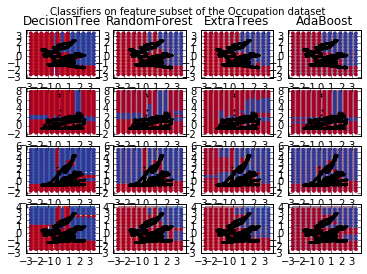

In [13]:
#parameters:temperature, humidity, light, co2, humidityratio
#target: occupancy = 0 or 1


#load data

df = pd.read_csv("datatraining.txt")
df.dropna(how = 'all', inplace = True)

df_test = pd.read_csv("datatest.txt") #a separate file for testing
df_test.dropna(how = 'all', inplace = True)

x_train = np.array(df.drop(["date","Occupancy"],1))
y_train = np.array(df["Occupancy"])

x_test = np.array(df_test.drop(["date","Occupancy"],1))
y_test = np.array(df_test["Occupancy"])

plot_idx = 1 #plot index

models = [DecisionTreeClassifier(max_depth=None),
         RandomForestClassifier(n_estimators=n_estimators),
         ExtraTreesClassifier(n_estimators=n_estimators),
         AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=n_estimators)]

for pair in ([0,1],[0,2],[0,3],[0,4]): #only two features at a time: temperature paired with humidity, light, co2 or humratio
    for model in models:
        X = x_train[:,pair]
        y = y_train
        
        X_test = x_test[:,pair]
        y_test = y_test
        
        #shuffle
        idx = np.arange(X.shape[0])
        np.random.seed(RANDOM_SEED)
        X = X[idx]
        y = y[idx]
        
        #standardize
        mean = X.mean(axis=0)
        std = X.std(axis=0)
        X = (X-mean)/std
        
        mean = X_test.mean(axis=0)
        std = X_test.std(axis=0)
        X_test = (X_test-mean)/std
                
        #train
        clf = clone(model)
        clf = model.fit(X,y)
        
        #test
        scores = clf.score(X_test,y_test)
        
        model_title = str(type(model)).split(".")[-1][:-2][:-len("Classifier")]
        model_details = model_title
        if hasattr(model, "estimators_"):
            model_details += "with {} estimators".format(len(model.estimators_))
        print(model_details + " with features", pair, "has a score of", scores)
        
        plt.subplot(4, 4, plot_idx)
        if plot_idx <= len(models):
            plt.title(model_title)
            
        #fine mesh
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))
        
        if isinstance(model, DecisionTreeClassifier):
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            cs = plt.contourf(xx, yy, Z, cmap=cmap)
            
        else:
            estimator_alpha = 1.0 / len(model.estimators_)
            for tree in model.estimators_:
                Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)
                cs = plt.contourf(xx, yy, Z, alpha =estimator_alpha, cmap=cmap)
                
        #coarser grid
        xx_coarser, yy_coarser = np.meshgrid(np.arange(x_min, x_max, plot_step_coarser),
                                            np.arange(y_min, y_max, plot_step_coarser))
        Z_points_coarser = model.predict(np.c_[xx_coarser.ravel(), yy_coarser.ravel()]).reshape(xx_coarser.shape)
        cs_points = plt.scatter(xx_coarser, yy_coarser, s=15, c=Z_points_coarser, cmap=cmap, edgecolors="none")
        
        #plot training points
        
        for i, c in zip(xrange(n_classes), plot_colors):
            idx = np.where(y == i)
            plt.scatter(X[idx, 0], X[idx, 1], c=c, label=y_test[i], cmap=cmap, s=1)
            
        plot_idx += 1
    
plt.suptitle("Classifiers on feature subset of the Occupation dataset")
plt.axis("tight")
                
                
        